In [1]:
############################### MISE EN PLACE DU CNN
import torch
from torch.autograd import Variable
from torch.optim import Adam, SGD

import torch.nn as nn
import torch.optim as optim

batch_size = 1
epochs = 50
learning_rate = 2e-3

In [2]:
############################## CRÉATION DU DATASET

import torch
import torchvision
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import torchaudio
import numpy as np
import matplotlib.image as mpimg
from torch import tensor
import os
from torchvision.transforms import ToTensor
from PIL import Image 
from sklearn.preprocessing import normalize

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)


i=0
dico={}

def my_loader(filename):
    spec = np.load(filename)
    norm = np.max(spec) - np.min(spec)
    spec_db = -20*np.log10(spec/norm)
    norm_db = np.max(spec_db) - np.min(spec_db)
    spec_db = spec_db / norm_db
#     global i
#     global dico
#     dico.update({"filename" : [i, norm, norm_db]})
#     i+=1
    return spec_db.astype('float32')

def my_loader_0(filename):
    spec = np.load(filename)
    norm = np.max(spec) - np.min(spec)
    spec_db = -20*np.log10(spec/norm)
    norm_db = np.max(spec_db) - np.min(spec_db)
    spec_db = spec_db / norm_db
    return spec_db.astype('float32')
    
# data_clear = torchvision.datasets.DatasetFolder('../Data/Spec_TEST_SNR_5/Clear/Modulus', transform = ToTensor(), loader = my_loader, extensions = ".npy")
# data_noisy = torchvision.datasets.DatasetFolder('../Data/Spec_TEST_SNR_5/Noisy/Modulus', transform = ToTensor(), loader = my_loader, extensions = ".npy")


data_clear = torchvision.datasets.DatasetFolder('../Data/test/Clear/Modulus', transform = ToTensor(), loader = my_loader, extensions = ".npy")
data_noisy = torchvision.datasets.DatasetFolder('../Data/test/Noisy/Modulus', transform = ToTensor(), loader = my_loader, extensions = ".npy")

test_loader = torch.utils.data.DataLoader(data_noisy, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader_clear = torch.utils.data.DataLoader(data_clear, batch_size=batch_size, shuffle=False, pin_memory=True)

Device:  cuda


In [3]:
a=data_clear.__getitem__(0)
print(np.shape(a[0]))
# len(a[0][0][1])

print(np.max(a[0][0].numpy()))
spectro = a[0][0].numpy()
print(spectro)
# it= iter(test_loader)
# next(it)

# np.shape(data_clear[0][1])
# data_clear[0]


# for [a,_],[b,_] in zip(test_loader, test_loader_clear):
#     print("a=",a)
#     print("b=",b)
    
# for batch_features, _ in test_loader:
#     print("batch_features=", batch_features)

torch.Size([1, 257, 124])
0.99999994
[[0.40028167 0.40469232 0.38980404 ... 0.44807997 0.3953609  0.3939197 ]
 [0.44719192 0.46268648 0.42833298 ... 0.52330226 0.45400655 0.43746534]
 [0.57174224 0.55300593 0.52038074 ... 0.56061655 0.5243643  0.56054   ]
 ...
 [0.683146   0.65876    0.6975184  ... 0.6408347  0.63578784 0.62310416]
 [0.68335354 0.7167642  0.5888047  ... 0.6755781  0.6284945  0.6395345 ]
 [0.6821433  0.87899363 0.62081426 ... 0.91184765 0.67491984 0.6680524 ]]


In [4]:
# from PIL import Image
# im = (spectro*255)
# img = Image.fromarray(im).convert("L")
# img.save('spectro.png')

In [5]:
# clear=data_clear.__getitem__(0)[0][0]
# noisy=data_noisy.__getitem__(0)[0][0]

# plt.figure(0)
# plt.imshow(clear, cmap='gray', aspect='auto', origin='lower')

# plt.figure(1)
# plt.imshow(noisy, cmap='gray', aspect='auto', origin='lower')

In [6]:
# path = '../Data/test/Dataset/'
# noisy = my_loader(path+'bruite/Data/b_sig_1_0.npy')
# clear = my_loader(path+'non_bruite/Data/nb_sig_1_0.npy')

# clear = my_loader('../Data/Spec_TEST/Clear/Modulus/Data/c_sig_2_0_mod.npy')
# noisy = my_loader('../Data/Spec_TEST/Noisy/Modulus/Data/n_sig_2_0_mod.npy')



# plt.figure(0)
# plt.imshow(clear, cmap='gray', aspect='auto', origin='lower')

# plt.figure(1)
# plt.imshow(noisy, cmap='gray', aspect='auto', origin='lower')


In [7]:
import torch.nn as nn
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer1 = nn.Conv2d(
            in_channels=1, out_channels=100, kernel_size=(25, 20), padding=(1,0)
        )
        self.encoder_hidden_layer2 = nn.Conv2d(
            in_channels=100, out_channels=500, kernel_size=(15, 5), padding=(1,2), groups=100
        )
        self.encoder_hidden_layer3 = nn.Conv2d(
            in_channels=500, out_channels=2000, kernel_size=(3, 3), padding=(1, 2)
        )
        self.poolp = nn.MaxPool2d(
            kernel_size=2, padding=(0,1)
        )
        self.pool = nn.MaxPool2d(
            kernel_size=2
        )
        self.avgpool = nn.AvgPool2d(
            kernel_size=2
        )
        self.decoder_hidden_layer1 = nn.ConvTranspose2d(
            in_channels=2000, out_channels=500, kernel_size=(3, 3), stride=2, padding=(0,1)
        )
        self.decoder_hidden_layer2 = nn.ConvTranspose2d(
            in_channels=500, out_channels=100, kernel_size=(15, 5), stride=2, padding=(1,1)
        )
        self.decoder_output_layer = nn.ConvTranspose2d(
            in_channels=100, out_channels=1, kernel_size=(25, 20), stride=2, padding=(0,2)
        )


    def forward(self, features):
#         print("features", features.size())

        encode1 = self.encoder_hidden_layer1(features)
        encode1 = torch.relu(encode1)
        encode1 = self.avgpool(encode1)
#         print("couche encode 1", encode1.size())

        encode2 = self.encoder_hidden_layer2(encode1)
        encode2 = torch.relu(encode2)
        encode2 = self.avgpool(encode2)
#         print("couche encode 2", encode2.size())

        encode3 = self.encoder_hidden_layer3(encode2)
        encode3 = torch.relu(encode3)
        encode3 = self.avgpool(encode3)
#         print("couche encode 3", encode3.size())

        decode1 = self.decoder_hidden_layer1(encode3)
        decode1 = torch.relu(decode1)
#         print("couche decode 1", decode1.size())

        decode2 = self.decoder_hidden_layer2(decode1)
        decode2 = torch.relu(decode2)
#         print("couche decode 2", decode2.size())

        decode3 = self.decoder_output_layer(decode2)
        decode3 = torch.tanh(decode3)
#         print("couche decode 3", decode3.size())

        decode3 = decode3[:, :, 0:features.size()[2], 0:features.size()[3]]

#         print("couche decode 3 crop", decode3.size())
        return decode3
        
 



In [8]:
# features torch.Size([10, 1, 257, 124])
# couche encode 1 torch.Size([10, 100, 101, 55])
# couche encode 2 torch.Size([10, 500, 46, 20])
# couche encode 3 torch.Size([10, 2000, 22, 10])
# couche decode 1 torch.Size([10, 500, 26, 14])
# couche decode 2 torch.Size([10, 100, 36, 28])
# couche decode 3 torch.Size([10, 1, 89, 36])
# couche decode 3 crop torch.Size([10, 1, 89, 36])

In [9]:
# #  use gpu if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if (device == "cuda"):
    torch.cuda.empty_cache()

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)


# mean-squared error loss
criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# criterion = nn.SmoothL1Loss()

In [10]:
# torch.cuda.empty_cache()

In [11]:
# load model
# model = AE().to(device)
# model.load_state_dict(torch.load("model_V0/model19.pt"))
# model.train()

for epoch in range(epochs):
    loss = 0
#     for batch_features, _ in test_loader:
    for [batch_features,_],[batch_features_clear,_] in zip(test_loader, test_loader_clear):
        batch_features = batch_features.to(device)
        batch_features_clear = batch_features_clear.to(device)
#         print(batch_features.type())
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        # compute reconstructions
#         outputs = model(torch.tensor(batch_features, device=device))
        outputs = model(batch_features.clone().detach())


#         outputs = model(batch_features)

#         print(outputs.size())
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features_clear)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        del train_loss
        del outputs
        
    # compute the epoch training loss
    loss = loss / len(test_loader)
    
    # save the weigth
    torch.save(model.state_dict(), "model/model"+str(epoch+1)+".pt")
    
    # display the epoch training loss
    print("epoch : {}/{}, Training loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/50, Training loss = 0.06290611
epoch : 2/50, Training loss = 0.02004673
epoch : 3/50, Training loss = 0.01861012
epoch : 4/50, Training loss = 0.01779018
epoch : 5/50, Training loss = 0.01623577
epoch : 6/50, Training loss = 0.01468550
epoch : 7/50, Training loss = 0.01383868
epoch : 8/50, Training loss = 0.01330749
epoch : 9/50, Training loss = 0.01282611
epoch : 10/50, Training loss = 0.01238727
epoch : 11/50, Training loss = 0.01199298
epoch : 12/50, Training loss = 0.01165228
epoch : 13/50, Training loss = 0.01135097
epoch : 14/50, Training loss = 0.01110632
epoch : 15/50, Training loss = 0.01094638
epoch : 16/50, Training loss = 0.01074077
epoch : 17/50, Training loss = 0.01059685
epoch : 18/50, Training loss = 0.01045743
epoch : 19/50, Training loss = 0.01032973
epoch : 20/50, Training loss = 0.01021370
epoch : 21/50, Training loss = 0.01011247
epoch : 22/50, Training loss = 0.01001731
epoch : 23/50, Training loss = 0.00994846
epoch : 24/50, Training loss = 0.00985896
e

In [12]:
########################### Prédiction


#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE().to(device)
# model = autoencoder().to(device)


# load model
model.load_state_dict(torch.load("model/model50.pt"))
model.eval()

with torch.no_grad():
    i=0
    for batch_features, _ in test_loader:
        batch_features = batch_features.to(device)
#         print(type(batch_features))
        outputs = model(batch_features.clone().detach())
#         print(type(outputs))
        np.save('../Data/test/Predict/output_' + str(i) + '.npy', outputs.cpu().numpy().astype(np.float32))
        i+=1



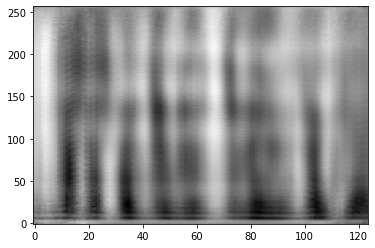

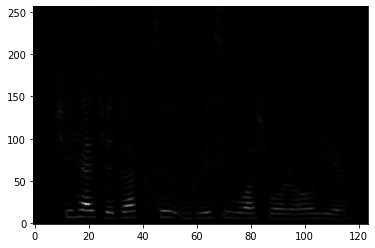

In [24]:
name = "output_1"
path = "../Data/test/Predict/"
spec = np.load(path+name+".npy")
spec_n = np.load("../Data/test/Noisy/Modulus/Data/n_sig_1_0_mod.npy")
plt.figure(0)
plt.imshow(spec[0][0], cmap='gray', aspect='auto', origin='lower')
plt.savefig("spectro_débruité.png")

plt.figure(1)
plt.imshow(spec_n, cmap='gray', aspect='auto', origin='lower')
# np.max(spec[0][0])

In [14]:
loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
print(output)
output.backward()
print(input)
print(target)
print(output)


tensor(1.5661, grad_fn=<MseLossBackward>)
tensor([[ 0.0636, -0.1205,  0.3070,  0.6741,  1.5139],
        [ 0.2139,  0.3174, -0.4303,  0.5733, -0.8024],
        [ 0.7442,  0.4491, -1.1078, -1.5586, -1.3856]], requires_grad=True)
tensor([[-0.6185, -1.1867,  0.6439,  0.1020,  0.2659],
        [ 1.7834,  0.1764, -1.3415, -0.1553, -2.8783],
        [-0.3129, -0.0375, -0.3294,  1.1180,  0.2309]])
tensor(1.5661, grad_fn=<MseLossBackward>)


torch.Size([1, 48000])
(2, 47232)


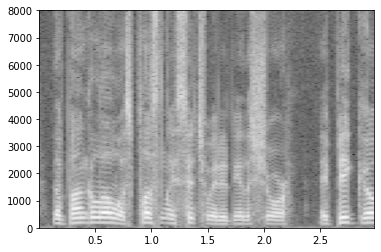

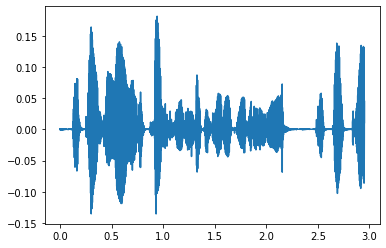

In [15]:
from scipy.signal import istft
import cmath
from scipy.io.wavfile import write
nprect = np.vectorize(cmath.rect)


waveform, sample_rate = torchaudio.load("../Data/meme_taille_TEST/sig_1_0.WAV")
phase, f_br, t_br, im_br = plt.specgram(waveform[0].t().numpy(), Fs = sample_rate, NFFT = 512, scale_by_freq = False, mode = 'phase', cmap = 'gray')
magnitude, f_br, t_br, im_br = plt.specgram(waveform[0].t().numpy(), Fs = sample_rate, NFFT = 512, scale_by_freq = False, mode = 'magnitude', cmap = 'gray')

spec = nprect(magnitude, phase)

sig = istft(spec, fs=sample_rate, nfft=512, nperseg=512, noverlap=128)
print(np.shape(waveform))
print(np.shape(sig))

plt.figure(0)
plt.plot(sig[0], sig[1])

write("coucou.wav",sample_rate,sig[1])

In [16]:
magnitude

array([[5.43234248e-05, 8.29582544e-05, 8.38893174e-05, ...,
        1.95365375e-05, 4.88824380e-05, 6.50441596e-05],
       [2.38067911e-05, 4.91405066e-05, 3.90247153e-05, ...,
        1.60504764e-05, 3.73857665e-05, 2.08662979e-05],
       [8.81097338e-06, 9.94406378e-06, 1.04395298e-05, ...,
        3.21614934e-05, 1.43911072e-05, 1.40674604e-05],
       ...,
       [4.65284132e-07, 1.47155123e-06, 2.77760435e-06, ...,
        8.16955523e-05, 9.83151974e-06, 4.79044387e-06],
       [1.33802595e-06, 9.29702596e-07, 2.79482184e-06, ...,
        7.23590284e-05, 1.41373782e-05, 3.50967829e-06],
       [1.49971451e-06, 3.41903107e-07, 4.03924860e-06, ...,
        7.16641372e-05, 1.83188641e-05, 1.97570442e-06]])

In [17]:
norm = (np.max(magnitude)-np.min(magnitude))
mag_norm = magnitude/norm
mag_norm

array([[1.41893447e-03, 2.16687970e-03, 2.19119918e-03, ...,
        5.10296737e-04, 1.27681523e-03, 1.69896136e-03],
       [6.21836280e-04, 1.28355601e-03, 1.01933031e-03, ...,
        4.19240397e-04, 9.76520771e-04, 5.45030241e-04],
       [2.30143697e-04, 2.59740156e-04, 2.72681789e-04, ...,
        8.40062121e-04, 3.75897471e-04, 3.67443776e-04],
       ...,
       [1.21532782e-05, 3.84370973e-05, 7.25513637e-05, ...,
        2.13389777e-03, 2.56800492e-04, 1.25126977e-04],
       [3.49494005e-05, 2.42839449e-05, 7.30010866e-05, ...,
        1.89002663e-03, 3.69270040e-04, 9.16732239e-05],
       [3.91727255e-05, 8.93055077e-06, 1.05505665e-04, ...,
        1.87187598e-03, 4.78490958e-04, 5.16056398e-05]])

In [18]:
mag_db = 20*np.log10(mag_norm)
mag_db

array([[ -56.96075324,  -53.28330398,  -53.18636287, ...,  -65.84354418,
         -57.87743892,  -55.39632994],
       [ -64.12647887,  -57.8317035 ,  -59.83370122, ...,  -67.55073753,
         -60.2063703 ,  -65.27158801],
       [ -72.7600183 ,  -71.70921806,  -71.2868773 , ...,  -61.51377195,
         -68.49861193,  -68.69618208],
       ...,
       [ -98.30613125,  -88.30498835,  -82.7870884 , ...,  -53.41652782,
         -71.80808297,  -78.05298097],
       [ -89.13120539,  -92.29361521,  -82.73341351, ...,  -54.47064155,
         -68.65311853,  -80.7551499 ],
       [ -88.14032422, -100.98243513,  -79.53448442, ...,  -54.55445855,
         -66.40252529,  -85.74605666]])

array([[1.41893447e-03, 2.16687970e-03, 2.19119918e-03, ...,
        5.10296737e-04, 1.27681523e-03, 1.69896136e-03],
       [6.21836280e-04, 1.28355601e-03, 1.01933031e-03, ...,
        4.19240397e-04, 9.76520771e-04, 5.45030241e-04],
       [2.30143697e-04, 2.59740156e-04, 2.72681789e-04, ...,
        8.40062121e-04, 3.75897471e-04, 3.67443776e-04],
       ...,
       [1.21532782e-05, 3.84370973e-05, 7.25513637e-05, ...,
        2.13389777e-03, 2.56800492e-04, 1.25126977e-04],
       [3.49494005e-05, 2.42839449e-05, 7.30010866e-05, ...,
        1.89002663e-03, 3.69270040e-04, 9.16732239e-05],
       [3.91727255e-05, 8.93055077e-06, 1.05505665e-04, ...,
        1.87187598e-03, 4.78490958e-04, 5.16056398e-05]])

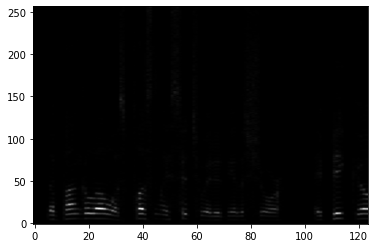

In [19]:
a = 10**(mag_db/20)
plt.imshow(a, cmap='gray', aspect='auto', origin='lower')
a

In [20]:
b = a * norm 
b

array([[5.43234248e-05, 8.29582544e-05, 8.38893174e-05, ...,
        1.95365375e-05, 4.88824380e-05, 6.50441596e-05],
       [2.38067911e-05, 4.91405066e-05, 3.90247153e-05, ...,
        1.60504764e-05, 3.73857665e-05, 2.08662979e-05],
       [8.81097338e-06, 9.94406378e-06, 1.04395298e-05, ...,
        3.21614934e-05, 1.43911072e-05, 1.40674604e-05],
       ...,
       [4.65284132e-07, 1.47155123e-06, 2.77760435e-06, ...,
        8.16955523e-05, 9.83151974e-06, 4.79044387e-06],
       [1.33802595e-06, 9.29702596e-07, 2.79482184e-06, ...,
        7.23590284e-05, 1.41373782e-05, 3.50967829e-06],
       [1.49971451e-06, 3.41903107e-07, 4.03924860e-06, ...,
        7.16641372e-05, 1.83188641e-05, 1.97570442e-06]])

torch.Size([1, 48000])
(2, 47232)


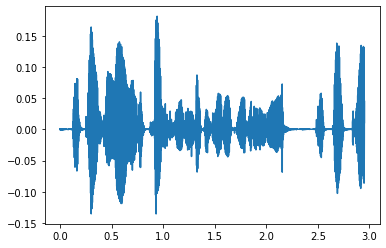

In [21]:
spec = nprect(b, phase)
sig = istft(spec, fs=sample_rate, nfft=512, nperseg=512, noverlap=128)
print(np.shape(waveform))
print(np.shape(sig))

plt.figure(0)
plt.plot(sig[0], sig[1])

write("coucou_n.wav",sample_rate,sig[1])

torch.Size([1, 48000])
(2, 47232)


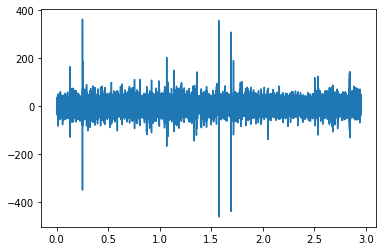

In [22]:
from scipy.signal import istft
import cmath
from scipy.io.wavfile import write
nprect = np.vectorize(cmath.rect)


spec_db = np.load("../Data/test/Predict/output_1.npy")[0][0]
magnitude = 10**(-spec_db/20)
phase = np.load("../Data/Spec_TEST_SNR_5/Noisy/Phase/n_sig_1_0_phi.npy")

waveform, sample_rate = torchaudio.load("../Data/meme_taille_TEST/sig_1_0.WAV")
# phase, f_br, t_br, im_br = plt.specgram(waveform[0].t().numpy(), Fs = sample_rate, NFFT = 512, scale_by_freq = False, mode = 'phase', cmap = 'gray')
# magnitude, f_br, t_br, im_br = plt.specgram(waveform[0].t().numpy(), Fs = sample_rate, NFFT = 512, scale_by_freq = False, mode = 'magnitude', cmap = 'gray')

spec = nprect(magnitude, phase)

sig = istft(spec, fs=sample_rate, nfft=512, nperseg=512, noverlap=128)
print(np.shape(waveform))
print(np.shape(sig))

plt.figure(0)
plt.plot(sig[0], sig[1])

write("coucou_den.wav",sample_rate,sig[1])